## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("giphy_with_descriptions.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10972 entries, 0 to 10971
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   GIF ID                10972 non-null  object
 1   Web Archive Link      10972 non-null  object
 2   MD5 Hash              10972 non-null  object
 3   File Size (In Bytes)  10972 non-null  int64 
 4   GIPHY Title           10461 non-null  object
 5   Import Date           10656 non-null  object
 6   Trending Date         10656 non-null  object
 7   Description           2608 non-null   object
dtypes: int64(1), object(7)
memory usage: 685.9+ KB


In [3]:
giphy_data = df[
    df['GIPHY Title'].notnull() &
    (df['GIPHY Title'] != '[empty]') &
    (df['GIPHY Title'] != 'NA')
]
giphy_data

giphy_data['GIPHY Title'] = giphy_data['GIPHY Title'].str.replace(r'\bGIF\b', '', regex=True).str.strip()

/var/folders/0_/492vkfd907l731l24rh69fww0000gn/T/ipykernel_54524/2260444410.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data['GIPHY Title'] = giphy_data['GIPHY Title'].str.replace(r'\bGIF\b', '', regex=True).str.strip()


In [4]:
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load spaCy's English model
nlp = spacy.load("en_core_web_sm")

# Define an enhanced preprocessing function
def preprocess_titles_enhanced(title):
    """
    Enhanced preprocessing for extracting sentiment and keywords from titles.
    """
    if pd.isna(title):
        return {"emotion": "unknown", "keywords": []}

    # Clean and tokenize the title using spaCy
    doc = nlp(title.lower())
    tokens = [token.lemma_ for token in doc if token.is_alpha and token.text not in ENGLISH_STOP_WORDS]

    # Extract sentiment polarity and categorize into emotions
    sentiment = TextBlob(title).sentiment.polarity
    if sentiment > 0.3:
        emotion = "positive"
    elif sentiment < -0.3:
        emotion = "negative"
    else:
        emotion = "neutral"

    # Extract keywords by filtering nouns and adjectives
    keywords = [token.text for token in doc if token.pos_ in {"NOUN", "ADJ"}]

    return {"emotion": emotion, "keywords": keywords}


giphy_data["processed"] = giphy_data["GIPHY Title"].apply(preprocess_titles_enhanced)

# Extract the processed information into separate columns for display
giphy_data["emotion"] = giphy_data["processed"].apply(lambda x: x["emotion"])
giphy_data["keywords"] = giphy_data["processed"].apply(lambda x: x["keywords"])

# Drop the intermediate 'Processed' column for clarity
dataset = giphy_data.drop(columns=['processed'])
dataset
dataset.to_csv("cleangiphy.csv")

/var/folders/0_/492vkfd907l731l24rh69fww0000gn/T/ipykernel_54524/2205027210.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data["processed"] = giphy_data["GIPHY Title"].apply(preprocess_titles_enhanced)
/var/folders/0_/492vkfd907l731l24rh69fww0000gn/T/ipykernel_54524/2205027210.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  giphy_data["emotion"] = giphy_data["processed"].apply(lambda x: x["emotion"])
/var/folders/0_/492vkfd907l731l24rh69fww0000gn/T/ipykernel_54524/2205027210.py:39: Setting

## Model #1 (Old Model)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

# Prepare data for clustering
# Convert emotions to numerical labels
label_encoder = LabelEncoder()
emotion_labels = label_encoder.fit_transform(dataset['emotion'])

# Vectorize the keywords using TF-IDF
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
keywords_vectorized = vectorizer.fit_transform(dataset['keywords'].apply(lambda x: " ".join(x)))

# Combine emotion labels and TF-IDF vectors for clustering
from scipy.sparse import hstack
features = hstack([keywords_vectorized, emotion_labels.reshape(-1, 1)])

# Apply K-Means clustering
num_clusters = 5  # Set number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
dataset['Cluster'] = kmeans.fit_predict(features)

# Analyze cluster distribution
cluster_summary = dataset.groupby('Cluster').size()

cluster_summary


/Users/CookS21/Downloads/Class17-py/.conda/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Cluster
0      82
1    8637
2     869
3     692
4     181
dtype: int64

In [64]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

pd.set_option('display.max_colwidth', None)

# Function to process query
def process_query(query):
    # Use TextBlob for sentiment analysis to extract emotion from query
    sentiment = TextBlob(query).sentiment
    query_emotion = "positive" if sentiment.polarity > 0 else "negative" if sentiment.polarity < 0 else "neutral"

    # Vectorize the query keywords using the same vectorizer
    query_keywords_vector = vectorizer.transform([query])

    return query_emotion, query_keywords_vector

# Function to perform retrieval
def retrieve_gifs(query, top_n=10):
    # Process the query
    query_emotion, query_keywords_vector = process_query(query)

    # Match clusters by emotion similarity
    matching_clusters = dataset[dataset['emotion'] == query_emotion]

    if matching_clusters.empty:
        return "No matching clusters found for the specified emotion."

    # Compute cosine similarity for keywords within the matching clusters
    matching_keywords_vectors = vectorizer.transform(
        matching_clusters['keywords'].apply(lambda x: " ".join(x))
    )
    similarity_scores = cosine_similarity(query_keywords_vector, matching_keywords_vectors).flatten()

    # Add similarity scores to the dataset
    matching_clusters = matching_clusters.copy()
    matching_clusters['Similarity'] = similarity_scores

    # Rank by similarity score and select top N results
    top_results = matching_clusters.nlargest(top_n, 'Similarity')
    return top_results[['GIF ID', 'Web Archive Link', 'GIPHY Title', 'emotion', 'Similarity']]

# Example Query
query_example = "A happy moment"

results = retrieve_gifs(query_example)
results

,GIF ID,Web Archive Link,GIPHY Title,emotion,Similarity
3,1003Kuq13ICXDO,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1003Kuq13ICXDO/giphy.gif,love happy,positive,1.0
67,103wxMOQYiCOjK,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/103wxMOQYiCOjK/giphy.gif,happy sun,positive,1.0
130,1097v2ZAvP3lVC,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1097v2ZAvP3lVC/giphy.gif,happy christina aguilera,positive,1.0
150,10aADbYxnJlc9q,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/10aADbYxnJlc9q/giphy.gif,happy global warming,positive,1.0
232,10d3NDzD40xb0s,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/10d3NDzD40xb0s/giphy.gif,happy sun by Pasquale D'Silva,positive,1.0
741,10ttqzrQQODtUk,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/10ttqzrQQODtUk/giphy.gif,happy benedict cumberbatch,positive,1.0
966,1136UBdSNn6Bu8,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1136UBdSNn6Bu8/giphy.gif,happy rabbit,positive,1.0
994,115mVjBnNptwUE,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/115mVjBnNptwUE/giphy.gif,happy sansa stark,positive,1.0
1367,11lkl2WndSu3e0,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/11lkl2WndSu3e0/giphy.gif,happy ratatouille,positive,1.0
1407,11MrfxzOCYgam4,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/11MrfxzOCYgam4/giphy.gif,happy katie mcgrath,positive,1.0


## Model #2 (New Model)

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
import numpy as np

# Fill missing values in titles and descriptions with empty strings
dataset['GIPHY Title'] = dataset['GIPHY Title'].fillna('')
dataset['Description'] = dataset['Description'].fillna('')

# Combine keywords, titles, and descriptions into a single text field for vectorization
dataset['combined_text'] = dataset.apply(
    lambda row: ' '.join(row['keywords']).replace("'", "").replace("[", "").replace("]", "") +
                ' ' + row['GIPHY Title'] + ' ' + row['Description'],
    axis=1
)

# Vectorize the combined text using TF-IDF
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
combined_vectorized = vectorizer.fit_transform(dataset['combined_text'])

print(f"Dataset Index: {dataset.index}")  # Indices of the dataset
print(f"Combined Vectorized Shape: {combined_vectorized.shape[0]}")  # Number of rows in the sparse matrix
# Function to process query with sentiment analysis and vectorization
def process_query(query):
    # Use TextBlob for sentiment analysis to extract emotion from query
    sentiment = TextBlob(query).sentiment
    query_emotion = "positive" if sentiment.polarity > 0 else "negative" if sentiment.polarity < 0 else "neutral"

    # Vectorize the query text
    query_vector = vectorizer.transform([query])

    return query_emotion, query_vector

# Function to perform retrieval based on combined text similarity
def retrieve_gifs_fixed(query, top_n=10):
    # Process the query
    query_emotion, query_vector = process_query(query)

    # Filter dataset by matching emotions
    matching_gifs = dataset[dataset['emotion'] == query_emotion].reset_index(drop=True)

    if matching_gifs.empty:
        return "No matching GIFs found for the specified emotion."

    # Select rows from the sparse matrix corresponding to the filtered dataset
    matching_indices = matching_gifs.index.to_numpy()
    matching_vectors = combined_vectorized[matching_indices]

    # Compute cosine similarity with the combined text
    similarity_scores = cosine_similarity(query_vector, matching_vectors).flatten()

    # Add similarity scores to the filtered dataset
    matching_gifs = matching_gifs.copy()
    matching_gifs['Similarity'] = similarity_scores

    # Rank by similarity score and select top N results
    top_results = matching_gifs.nlargest(top_n, 'Similarity')
    return top_results[['GIF ID', 'Web Archive Link', 'GIPHY Title', 'Description', 'emotion', 'Similarity']]

# Example Query
query_example = "Feeling Nervous"

# Retrieve GIFs for the query
results = retrieve_gifs(query_example)

results


Dataset Index: Index([    0,     1,     2,     3,     4,     5,     7,     8,     9,    10,
       ...
       10962, 10963, 10964, 10965, 10966, 10967, 10968, 10969, 10970, 10971],
      dtype='int64', length=10461)
Combined Vectorized Shape: 10461


,GIF ID,Web Archive Link,GIPHY Title,emotion,Similarity
0,1000eGIbYHercI,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1000eGIbYHercI/giphy.gif,slipper,neutral,0.0
1,1000fHsBSKSL6w,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1000fHsBSKSL6w/giphy.gif,swag hustling,neutral,0.0
2,1000WjcUQeqOaY,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1000WjcUQeqOaY/giphy.gif,jennifer lawrence salute,neutral,0.0
4,1004D5v8Dbe6cw,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1004D5v8Dbe6cw/giphy.gif,visual album beyonce,neutral,0.0
5,1004Eqp3k9U6KQ,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/1004Eqp3k9U6KQ/giphy.gif,the muppets nodding,neutral,0.0
7,1007d28L3ZIjRe,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/1007d28L3ZIjRe/giphy.gif,bread eating,neutral,0.0
9,100ak1Sn7F3ius,http://webarchive.loc.gov/all/20150318155641/http://media.giphy.com/media/100ak1Sn7F3ius/giphy.gif,michael jackson dancing,neutral,0.0
11,100d6UtqKnuNuU,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/100d6UtqKnuNuU/giphy.gif,inuyasha,neutral,0.0
12,100hiniRFKa3OE,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/100hiniRFKa3OE/giphy.gif,cat watching,neutral,0.0
13,100J4cu5UbCnVm,http://webarchive.loc.gov/all/20150318155641/https://media.giphy.com/media/100J4cu5UbCnVm/giphy.gif,american crime story acs,neutral,0.0


## Evaluation

In [ ]:
annotated_queries = pd.read_csv("/50 Annotated Queries/annotated_queries_fixed.csv")
annotated_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Query      500 non-null    object
 1   GIF ID     500 non-null    object
 2   Relevance  500 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [55]:
relevance_map = {"Highly Relevant": 2, "Moderately Relevant": 1, "Not Relevant": 0}
annotated_queries['Relevance'] = annotated_queries['Relevance'].map(relevance_map)

### New Model Evaluation 

In [61]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(annotated_queries, top_n=10):
    precision_list = []
    recall_list = []
    f1_list = []

    for _, row in annotated_queries.iterrows():
        query = row['Query']
        relevant_gif_id = row['GIF ID']
        relevance_score = row['Relevance']

        # Retrieve top N GIFs for the query
        retrieved_gifs = retrieve_gifs_fixed(query, top_n)

        # Check if the relevant GIF is in the top N
        retrieved_ids = retrieved_gifs['GIF ID'].tolist()
        is_relevant = [1 if gif_id == relevant_gif_id else 0 for gif_id in retrieved_ids]
        true_labels = [1 if relevance_score > 0 else 0] * len(is_relevant)

        # Calculate precision, recall, and F1 for this query
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, is_relevant, average='binary', zero_division=0
        )

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Compute average precision, recall, and F1 scores
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)


    return avg_precision, avg_recall, avg_f1


In [62]:
precision, recall, f1 = evaluate_model(annotated_queries)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.1300
Recall: 0.0130
F1 Score: 0.0236


### Old Model Evaluation 

In [58]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model_old(annotated_queries, top_n=10):
    precision_list = []
    recall_list = []
    f1_list = []

    for _, row in annotated_queries.iterrows():
        query = row['Query']
        relevant_gif_id = row['GIF ID']
        relevance_score = row['Relevance']

        # Retrieve top N GIFs for the query
        retrieved_gifs = retrieve_gifs(query, top_n)

        # Check if the relevant GIF is in the top N
        retrieved_ids = retrieved_gifs['GIF ID'].tolist()
        is_relevant = [1 if gif_id == relevant_gif_id else 0 for gif_id in retrieved_ids]
        true_labels = [1 if relevance_score > 0 else 0] * len(is_relevant)

        # Calculate precision, recall, and F1 for this query
        precision, recall, f1, _ = precision_recall_fscore_support(
            true_labels, is_relevant, average='binary', zero_division=0
        )

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Compute average precision, recall, and F1 scores
    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_f1 = np.mean(f1_list)

    return avg_precision, avg_recall, avg_f1

In [59]:
precision_old, recall_old, f1_old = evaluate_model_old(annotated_queries)
print(f"Precision: {precision_old:.4f}")
print(f"Recall: {recall_old:.4f}")
print(f"F1 Score: {f1_old:.4f}")

Precision: 0.2560
Recall: 0.0256
F1 Score: 0.0465


### Plotting the Evaluation Scores

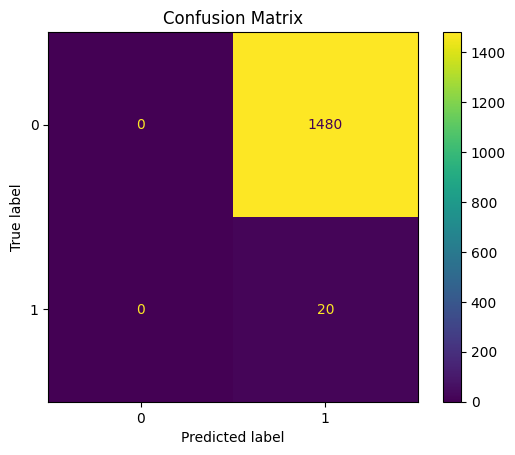

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Assuming binary relevance (relevant vs. not relevant)
y_true = []
y_pred = []

for _, row in annotated_queries.iterrows():
    query = row['Query']
    relevant_gifs = set(row['GIF ID'].split(','))
    top_results = retrieve_gifs(query, top_n=10)['GIF ID']
    y_true.append([1 if gif_id in relevant_gifs else 0 for gif_id in top_results])
    y_pred.append([1] * len(top_results))  # Predict all top-N as relevant

y_true_flat = np.concatenate(y_true)
y_pred_flat = np.concatenate(y_pred)

ConfusionMatrixDisplay.from_predictions(y_true_flat, y_pred_flat)
plt.title("Confusion Matrix")
plt.show()


/var/folders/0_/492vkfd907l731l24rh69fww0000gn/T/ipykernel_53265/2873790496.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=dataset, x='Cluster', palette='viridis')


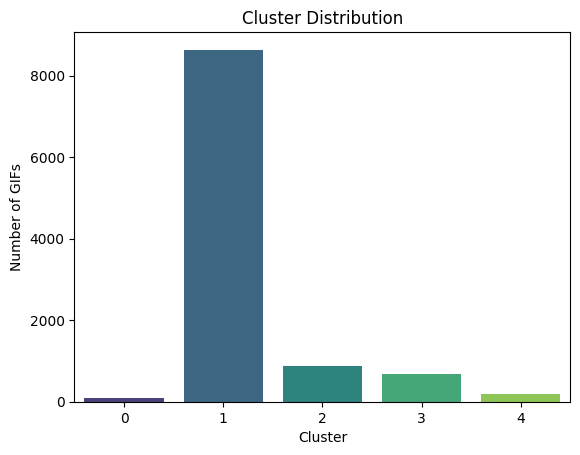

In [20]:
import seaborn as sns

sns.countplot(data=dataset, x='Cluster', palette='viridis')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Number of GIFs")
plt.show()

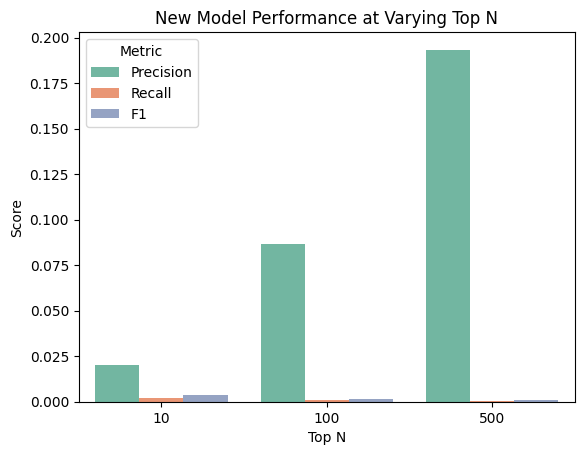

In [21]:
top_n_values = [10, 100, 500]
scores = {'Top N': [], 'Precision': [], 'Recall': [], 'F1': []}

for top_n in top_n_values:
    precision, recall, f1 = evaluate_model(annotated_queries, top_n=top_n)
    scores['Top N'].append(top_n)
    scores['Precision'].append(precision)
    scores['Recall'].append(recall)
    scores['F1'].append(f1)

scores_df = pd.DataFrame(scores)

sns.barplot(data=scores_df.melt(id_vars=['Top N'], var_name='Metric'), x='Top N', y='value', hue='Metric', palette='Set2')
plt.title("New Model Performance at Varying Top N")
plt.xlabel("Top N")
plt.ylabel("Score")
plt.show()


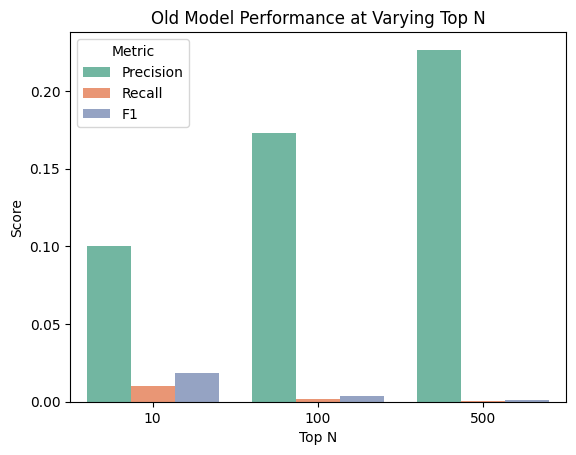

In [22]:
top_n_values_old = [10, 100, 500]
scores_old = {'Top N': [], 'Precision': [], 'Recall': [], 'F1': []}

for top_n in top_n_values_old:
    precision_old, recall_old, f1_old = evaluate_model_old(annotated_queries, top_n=top_n)
    scores_old['Top N'].append(top_n)
    scores_old['Precision'].append(precision_old)
    scores_old['Recall'].append(recall_old)
    scores_old['F1'].append(f1_old)

scores_df_old = pd.DataFrame(scores_old)

sns.barplot(data=scores_df_old.melt(id_vars=['Top N'], var_name='Metric'), x='Top N', y='value', hue='Metric', palette='Set2')
plt.title("Old Model Performance at Varying Top N")
plt.xlabel("Top N")
plt.ylabel("Score")
plt.show()
